# **Real-Time Speech Command Recognition using 2D-CNN**

## Hi, I’m Daivik Patel — an AI/ML enthusiast passionate about building intelligent systems that bridge the gap between raw data and meaningful insights.

This project is my second deep dive into audio processing — but unlike my first project (where I explored HMM + GMM for speech recognition using classical ML techniques), this one embraces deep learning.

Here, I implement a Custom 2D Convolutional Neural Network (CNN) for speech command recognition. The model listens to short audio clips and classifies them into different spoken words in real-time.

* **Why CNN for Audio?**

CNNs are excellent at recognizing patterns in images — and since spectrograms are essentially images of sound, CNNs can efficiently capture speech features like pitch, energy, and harmonics.This project demonstrates how modern deep learning techniques outperform traditional ML pipelines by enabling end-to-end feature learning instead of manual feature engineering.

* **Connection to Previous Project**

If you’re new to audio processing, you can check out my first project — “Speech-To-Text Using HMM and GMM Models” — for a foundational understanding of classical approaches. But if your focus is on how CNNs process audio spectrograms, you can dive straight into this project.

## **Importing all the necessary libraries for this project**

### Python Standard Libraries

1) `os`, `sys`, `time`, `math`, `csv`, `json`, `shutil`, `zipfile`, `subprocess`, `random`, `statistics as stats`

General-purpose Python modules.

* `os`, `pathlib`- to manage dataset paths, folders, and saved models.
* `sys`- sometimes used for environment/path control (rarely in your case).
* `time`- measure training runtime per epoch.
* `math`- basic math operations (like log, floor, ceil).
* `csv`, `json`- reading/writing dataset metadata or saving logs.
* `shutil`- for moving/deleting files (e.g., cleanup).
* `zipfile`- unzip dataset archives.
* `subprocess`- run shell commands (e.g., download/unzip in Colab).
* `random`- for random augmentation choices.
* `statistics`- used to compute averages or aggregate stats like accuracy/F1 across folds.

2) `dataclasses (dataclass, asdict)`- 
Creates structured containers for configs and training logs.
In project: We wrap hyperparameters or experiment settings neatly in a dataclass instead of messy dicts.

3) `pathlib.Path`- 
Modern way to handle file and folder paths.
In project: e.g., `ARTIFACTS / "final_model.pth"` to save models.

4) `typing (Dict, List, Tuple)`- 
Type hints to make code cleaner.
In project: Helps readability `(Dict[str, int]` for label mappings).

5) `collections.Counter`- 
Counts frequency of items in a list.
In project: Used to check class distribution (how many samples per command).

### Data & Visualization Libraries

6) `numpy as np`- 
Core numerical computing library.
In project: Handling arrays (e.g., converting waveform to numpy, spectrogram to tensors).

7) `matplotlib.pyplot as plt`- 
Plotting library.
In project: Visualizing spectrograms, training curves, confusion matrices.

### PyTorch Core

8) `torch`-  
The main PyTorch library for tensors and deep learning.
In project: Everything from tensor operations → model → GPU training.

9) `torch.nn as nn`- 
Neural network building blocks (layers, loss functions).
In project: Used to define CNN layers (Conv2d, Linear, ReLU, etc.).

10) `torch.nn.functional as F`- 
Functions like F.relu, F.softmax, etc. (stateless ops).
In project: Activation functions and loss utilities.

11) `torch.optim as optim`- 
Optimizers like Adam, SGD.
In project: Training the CNN parameters with gradient descent.

### Audio-Specific

12) `torchaudio`- 
Audio processing library in PyTorch.
In project: Load .wav files, play with signals, resample to 16 kHz.

13) `torchaudio.transforms as T`- 
Ready-made transformations (Resample, MelSpectrogram, MFCC, etc.).
In project: Convert raw audio → log-mel spectrogram.

14) `torchaudio.functional as AF`- 
Lower-level audio operations.
In project: Adding background noise, applying filters, computing deltas.

### Training Utilities

15) `torch.utils.data.Dataset, DataLoader`- 
Dataset & batching system.
* In project: Dataset: defines how a single audio sample is read → preprocessed → returned.
* DataLoader: batches them, shuffles, and sends to GPU.

16) `tqdm.auto as tqdm`- 
Progress bar.
In project: Shows live training progress per batch/epoch in Colab.

In [ ]:
import os, sys, time, math, csv, json, shutil, zipfile, subprocess, random, statistics as stats
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Dict, List, Tuple
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as AF

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

In [ ]:
import warnings
warnings.filterwarnings("ignore", module="torchaudio") # suppress all warning messages coming from the torchaudio library

#### Controlling randomness and selecting the right hardware (GPU) for your project.

In [ ]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True # Lets PyTorch find the fastest algorithms for your GPU → speeds up training.
    torch.backends.cudnn.deterministic = False # Allows small randomness in GPU ops → better performance (if we set True, runs slower but more reproducible).
    torch.backends.cuda.matmul.allow_tf32 = True # Enables TensorFloat-32 precision on NVIDIA GPUs (Ampere & later).
                                                 # Speeds up matrix multiplications (important in CNNs)
                                                 # Slightly less precise, but in practice no accuracy drop.
    torch.backends.cudnn.allow_tf32 = True

#### Path structure of project in Google Drive

In [ ]:
PROJECT_ROOT = Path("/content/drive/MyDrive/NLP_Project") # main folder for your entire project
DATA_ROOT    = PROJECT_ROOT / "data" / "speech_commands_v2" # Folder where the raw dataset (Google Speech Commands V2) will be stored.
ARTIFACTS    = PROJECT_ROOT / "artifacts" # for saving model checkpoints, logs, results, etc.
FEATURES_DIR = PROJECT_ROOT / "features" # for preprocessed features (like Mel-Spectrograms).

for p in [PROJECT_ROOT, DATA_ROOT, ARTIFACTS, FEATURES_DIR]: # Creates folders automatically if they don’t exist.
    p.mkdir(parents=True, exist_ok=True)

#### Hyperparameters and training settings

In [ ]:
@dataclass
class PreprocCfg:
    sample_rate: int = 16000 # Read audio at 16 kHz standard for human speech
    clip_seconds: float = 1.0 # Each sample is fixed to 1 second, CNN needs fixed size.
    n_fft: int = 400 # Short-time Fourier transform (STFT), a method used to analyze how the frequency content of a signal changes over time. STFT window size (samples) 400/16000 ≈ 25 ms window. 20-25 ms is standard for speech
    hop_length: int = 160 # Step between adjacent STFT frames 160/16000 = ~100 frames/sec; good temporal resolution for short commands.
    win_length: int = 400 # Window length for the Hann window (same as n_fft) ensures full window is used.
    n_mels: int = 40 # Number of Mel filter banks (vertical resolution) 40 is a widely used sweet spot in KWS, richer than 20, lighter than 64/80.
    fmin: int = 20 # Min/max frequencies for Mel filterbank.
    fmax: int = 7600
    power: float = 2.0 # Use power spectrogram (magnitude²) before log-scaling
    top_db: float = 80.0 # Dynamic range limit used in amplitude→dB conversion. Avoids extreme negative dB values, keeps features numerically stable.
    eps: float = 1e-10 #Tiny constant added before log to avoid log(0)

CFG = PreprocCfg()
SAMPLE_RATE = CFG.sample_rate
TARGET_LEN  = int(CFG.sample_rate * CFG.clip_seconds)

# Data/Aug settings
USE_SPEC_AUG   = True # Enable SpecAugment (mask random time/frequency bands on spectrogram). Reduce overfitting
SNR_DB_RANGE   = (10, 25) # Signal-to-Noise Ratio range (in dB) for additive background noise. Higher dB = cleaner; lower dB = noisier
TIME_SHIFT_MS  = 100 # Randomly circular-shift waveform ±100 ms. Aligns robustness to speaking offset
GAIN_DB_RANGE  = (-6, 6) # andom volume gain between –6 and +6 dB. Models different mic distances and speaking loudness.
SILENCE_LABEL  = "__silence__" # Add a class representing “no speech / background”
INCLUDE_SILENCE = True

# Train/eval settings
BATCH_SIZE  = 128 # Number of samples per update step
NUM_WORKERS = 2 if torch.cuda.is_available() else 0   # set 0 if Colab warnings bother
EPOCHS      = 35 # Number of full passes over training set
LR          = 1e-3 # Learning rate for optimizer (AdamW). Standard starting point
WEIGHT_DECAY= 1e-4 # L2 regularization on weights. Reduce overfitting.
LABEL_SMOOTH= 0.05 # oftens the one-hot target distribution (e.g., 0.95 for true class, 0.05 spread over others). Prevents over-confidence & improves generalization and calibration.
GRAD_CLIP_NORM = 1.0 # Clip global gradient norm to 1.0. Prevents rare exploding gradients; stabilizes training.
EVAL_TEST_EVERY_EPOCH = True # Evaluate on test set each epoch

# Model settings
BASE_CH     = 48 # Base number of filters in the first conv block (then doubles). More channels = more feature capacity than 32, empirically improved val/test accuracy in your runs.
IN_CH       = 3  # Deltas capture velocity and acceleration of spectral changes—very helpful for distinguishing phonetic dynamics (e.g., “no” vs “go”).

#### Sanity check and environment summary

Just showing my environment in which I am working

In [ ]:
print(">>> ENV SUMMARY")
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__, "| Torchaudio:", torchaudio.__version__)
print("CUDA available:", torch.cuda.is_available(), "| Using device:", device)
if torch.cuda.is_available():
    print("CUDA runtime:", torch.version.cuda, "| GPU:", torch.cuda.get_device_name(0))
    x = torch.randn(2048, 2048, device="cuda"); y = torch.randn(2048, 2048, device="cuda")
    torch.cuda.synchronize(); t0 = time.time(); _ = x @ y; torch.cuda.synchronize()
    print(f"GPU matmul 2048x2048: {(time.time()-t0)*1000:.1f} ms (sanity OK)")

print("\n>>> FOLDERS")
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT   :", DATA_ROOT)
print("ARTIFACTS   :", ARTIFACTS)
print("FEATURES    :", FEATURES_DIR)

print("\n>>> AUDIO")
print("SAMPLE_RATE:", SAMPLE_RATE, "| CLIP_SECONDS:", CFG.clip_seconds, "| TARGET_LEN:", TARGET_LEN)

>>> ENV SUMMARY
Python: 3.12.11
PyTorch: 2.8.0+cu126 | Torchaudio: 2.8.0+cu126
CUDA available: True | Using device: cuda
CUDA runtime: 12.6 | GPU: Tesla T4
GPU matmul 2048x2048: 132.0 ms (sanity OK)

>>> FOLDERS
PROJECT_ROOT: /content/drive/MyDrive/NLP_Project
DATA_ROOT   : /content/drive/MyDrive/NLP_Project/data/speech_commands_v2
ARTIFACTS   : /content/drive/MyDrive/NLP_Project/artifacts
FEATURES    : /content/drive/MyDrive/NLP_Project/features

>>> AUDIO
SAMPLE_RATE: 16000 | CLIP_SECONDS: 1.0 | TARGET_LEN: 16000


#### Downloading and organizing the dataset

In [ ]:
# Makes sure your notebook has valid Kaggle API credentials. This function will look for kaggle.json file with wich we can downlaod the dataset from kaggle
def _ensure_kaggle_creds():
    candidate_paths = [Path("/content/drive/MyDrive/NLP_Project/kaggle.json"), # Path where kaggle.json file is
                       PROJECT_ROOT / "kaggle.json"]
    kaggle_json = next((p for p in candidate_paths if p.exists()), None)
    assert kaggle_json is not None, (
        "kaggle.json not found.\n"
        "Get it from Kaggle: Account > Create API Token.\n"
        "Then upload to /content/kaggle.json OR place it at "
        f"{PROJECT_ROOT/'kaggle.json'} and re-run."
    )
    os.makedirs("/root/.kaggle", exist_ok=True)
    shutil.copy(str(kaggle_json), "/root/.kaggle/kaggle.json")
    os.chmod("/root/.kaggle/kaggle.json", 0o600)
    try:
        import kaggle
    except Exception:
        print("Installing kaggle CLI...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "kaggle"])

# Downloads the SpeechCommands V2 dataset from Kaggle and extracting.
def download_dataset():
    _ensure_kaggle_creds()
    dataset_ref = "sylkaladin/speech-commands-v2"
    zip_path = Path("/content/speech-commands-v2.zip")
    if not zip_path.exists():
        print(f"Downloading {dataset_ref} ...")
        subprocess.check_call(["kaggle", "datasets", "download", "-d", dataset_ref, "-p", "/content", "-q"])
    else:
        print("Found existing ZIP:", zip_path)
    print("Extracting into:", DATA_ROOT)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(DATA_ROOT)
        
# For quickly showing what’s inside a given directory
def list_dir(p: Path, limit=30):
    items = sorted(p.iterdir())
    print(f"\n>>> Listing: {p} (showing up to {limit})")
    for i, it in enumerate(items[:limit]):
        kind = "DIR " if it.is_dir() else "FILE"
        print(f"  [{i:02d}] {kind} {it.name}")
    if len(items) > limit:
        print(f"  ... ({len(items)-limit} more)")

In [ ]:
download_dataset()
list_dir(DATA_ROOT) #Downloading the dataset in the root folder

Extracting into: /content/drive/MyDrive/NLP_Project/data/speech_commands_v2

>>> Listing: /content/drive/MyDrive/NLP_Project/data/speech_commands_v2 (showing up to 30)
  [00] FILE LICENSE
  [01] FILE README.md
  [02] DIR  _background_noise_
  [03] DIR  backward
  [04] DIR  bed
  [05] DIR  bird
  [06] DIR  cat
  [07] DIR  dog
  [08] DIR  down
  [09] DIR  eight
  [10] DIR  five
  [11] DIR  follow
  [12] DIR  forward
  [13] DIR  four
  [14] DIR  go
  [15] DIR  happy
  [16] DIR  house
  [17] DIR  learn
  [18] DIR  left
  [19] DIR  marvin
  [20] DIR  nine
  [21] DIR  no
  [22] DIR  off
  [23] DIR  on
  [24] DIR  one
  [25] DIR  right
  [26] DIR  seven
  [27] DIR  sheila
  [28] DIR  six
  [29] DIR  stop
  ... (10 more)


In [ ]:
# Figuring out what labels (words) are in your dataset and how many audio samples each label has.

def is_audio_dir(p: Path) -> bool:
    return p.is_dir() and any(str(f).lower().endswith(".wav") for f in p.rglob("*.wav"))

LABEL_DIRS = sorted([p for p in DATA_ROOT.iterdir() if is_audio_dir(p) and p.name != "_background_noise_"]) # Collects all valid audio directories inside DATA_ROOT
ALL_LABELS = [p.name for p in LABEL_DIRS] # Extracts just the folder names from
print(">>> LABELS (excluding background noise):", len(ALL_LABELS))
print(ALL_LABELS[:20], "...") # Prints how many unique labels exist. Prints first 20 label names (so you don’t flood the output).

counts = {lbl: sum(1 for _ in (DATA_ROOT/lbl).rglob("*.wav")) for lbl in ALL_LABELS} #Counting how many .wav per label
print("\n>>> FILE COUNTS (top 15)")
for lbl in sorted(counts, key=counts.get, reverse=True)[:15]:
    print(f"{lbl:20s}: {counts[lbl]:6d}")
print("TOTAL WAV FILES:", sum(counts.values())) # Shows the top 15 labels with most audio clips.Prints total number of .wav files in dataset.

>>> LABELS (excluding background noise): 35
['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off'] ...

>>> FILE COUNTS (top 15)
five                :   4052
zero                :   4052
yes                 :   4044
seven               :   3998
no                  :   3941
nine                :   3934
down                :   3917
one                 :   3890
go                  :   3880
two                 :   3880
stop                :   3872
six                 :   3860
on                  :   3845
left                :   3801
eight               :   3787
TOTAL WAV FILES: 105829


In [ ]:
# Random subset stats
all_wavs = [f for d in LABEL_DIRS for f in d.rglob("*.wav")] # Collects all .wav file paths into a single list all_wavs.
probe_files = random.sample(all_wavs, min(500, len(all_wavs))) if all_wavs else [] # Takes up to 500 random audio files from the dataset.

# Gathering sample rate & duration info
sr_list, dur_list, bad = [], [], []
for f in probe_files:
    try:
        info = torchaudio.info(f); sr_list.append(info.sample_rate); dur_list.append(info.num_frames / max(info.sample_rate, 1))
    except Exception as e:
        bad.append((f, str(e)))

def _stats(v): # Computes basic statistics (min, max, mean, median) for any list of numbers.
    return {"min": float(min(v)) if v else None, "max": float(max(v)) if v else None,
            "mean": float(stats.mean(v)) if v else None, "median": float(stats.median(v)) if v else None}

print("\n>>> SAMPLE RATE (subset):", _stats(sr_list))
print(">>> DURATION  (subset):", _stats(dur_list))
if bad: print(f"[WARN] {len(bad)} unreadable files; showing 3:", bad[:3])

/tmp/ipython-input-1075188712.py:7: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(f); sr_list.append(info.sample_rate); dur_list.append(info.num_frames / max(info.sample_rate, 1))



>>> SAMPLE RATE (subset): {'min': 16000.0, 'max': 16000.0, 'mean': 16000.0, 'median': 16000.0}
>>> DURATION  (subset): {'min': 0.4693125, 'max': 1.0, 'mean': 0.982605375, 'median': 1.0}


## This is where your raw waveform → model-ready features are defined.

We are building log-Mel spectrograms (and later deltas) on the CPU, which is the right choice for PyTorch DataLoader workers.

In [ ]:
# Mel spectrogram extractor this will converts a waveform [1 (1 is for Mono channel), T] into Mel spectrogram [1, n_mels, time] using hyperparameters that we have defineded earlier.
mel_extractor = T.MelSpectrogram(
    sample_rate=CFG.sample_rate, 
    n_fft=CFG.n_fft, 
    hop_length=CFG.hop_length, 
    win_length=CFG.win_length,
    n_mels=CFG.n_mels, 
    f_min=CFG.fmin, 
    f_max=CFG.fmax, 
    power=CFG.power, 
    window_fn=torch.hann_window
)

# Amplitude → dB (log compression)
amplitude_to_db = T.AmplitudeToDB(stype="power", top_db=CFG.top_db) # Maps power spectrogram values to log (dB) scale → “log-Mel”.

# This function Loads a .wav file, converts stereo to mono (since dataset is single-channel), resamples to 16kHz (your model’s fixed rate) and returns waveform [1, T].
def load_wav(path: Path, target_sr=CFG.sample_rate) -> torch.Tensor:
    wav, sr = torchaudio.load(path)
    if wav.shape[0] > 1: wav = torch.mean(wav, dim=0, keepdim=True)
    if sr != target_sr:  wav = T.Resample(sr, target_sr)(wav)
    return wav  # [1, T]

# Ensures every clip is exactly 1 second (16,000 samples), if shorter → pad with zeros and if longer → trim.
def pad_or_trim(wav: torch.Tensor, num_samples=TARGET_LEN) -> torch.Tensor:
    n = wav.shape[-1]
    if n < num_samples: return torch.nn.functional.pad(wav, (0, num_samples - n))
    return wav[..., :num_samples]

# Converts raw audio .wav to CNN ready features
def wav_to_logmel3(wav: torch.Tensor, use_specaug: bool) -> torch.Tensor:
    """
    Returns [3, n_mels, T]: [logmel, delta, delta2]
    - Per-channel per-sample normalization
    - Optional SpecAugment on base log-mel before deltas
    """
    with torch.no_grad():
        mel = mel_extractor(wav)                # Converts waveform to Mel-Spectrogram (40 Mel bands × time) [1, 40, T]
        logmel = amplitude_to_db(mel + CFG.eps) # Converts amplitude → decibels (log scale) for perceptual loudness. log scale [1, 40, T]

    # SpecAugment (on the base logmel channel)
    if use_specaug:
        x = logmel.clone(); _, Fm, Tm = x.shape
        # slightly stronger
        for _ in range(2):
            f = random.randint(0, 8)
            if f > 0:
                f0 = random.randint(0, max(0, Fm - f))
                x[:, f0:f0+f, :] = x.min()
        for _ in range(2):
            t = random.randint(0, 16)
            if t > 0:
                t0 = random.randint(0, max(0, Tm - t))
                x[:, :, t0:t0+t] = x.min()
        logmel = x

    # Deltas along time (CPU)
    delta  = AF.compute_deltas(logmel, win_length=5) # change over time (1st derivative) → speech speed, tone slope.
    delta2 = AF.compute_deltas(delta,   win_length=5) # change of change (2nd derivative) → acceleration of tone.

    feat = torch.cat([logmel, delta, delta2], dim=0)  # [3 (RGB image), 40, T]
    # Per-channel normalization ensures zero mean & unit variance → stabilizes training
    mean = feat.mean(dim=(-2, -1), keepdim=True)
    std  = feat.std(dim=(-2, -1), keepdim=True).clamp_min(1e-5)
    feat = (feat - mean) / std
    return feat

In [ ]:
# Waveform augmentations it randomly rolls the waveform a few milliseconds left/right. Real speech doesn’t always start at the exact same sample, this makes the model invariant to start-time alignment and reduces overfitting to onsets.
def time_shift(wav: torch.Tensor, max_shift_ms=TIME_SHIFT_MS):
    shift = int(CFG.sample_rate * random.uniform(-max_shift_ms, max_shift_ms) / 1000.0)
    return torch.roll(wav, shifts=shift, dims=-1) if shift else wav

#cScales amplitude by a random gain between, e.g., −6 dB and +6 dB this simulates different speaking volumes / mic distances so the model doesn’t latch onto absolute loudness.
def random_gain(wav: torch.Tensor, min_db=GAIN_DB_RANGE[0], max_db=GAIN_DB_RANGE[1]):
    return wav * (10 ** (random.uniform(min_db, max_db) / 20.0))

# Background Noise Injection this loads a handful of long noise recordings from the dataset’s _background_noise_ folder, converts to mono and 16 kHz, and caches them.
noise_bank = []
noise_dir = DATA_ROOT / "_background_noise_"
if noise_dir.exists():
    for nf in list(noise_dir.rglob("*.wav"))[:8]:
        w, sr = torchaudio.load(nf)
        if w.shape[0] > 1: w = torch.mean(w, dim=0, keepdim=True)
        if sr != SAMPLE_RATE: w = T.Resample(sr, SAMPLE_RATE)(w)
        noise_bank.append(w)

# Add background noise at a target SNR (Signal-to-Noise Ratio) this mixes speech with a random noise segment at a random from a given dB range, e.g., 10–25 dB.
def add_background(wav: torch.Tensor, snr_db_range=SNR_DB_RANGE):
    if not noise_bank: return wav
    noise = random.choice(noise_bank)
    if noise.shape[-1] < TARGET_LEN:
        reps = math.ceil(TARGET_LEN / noise.shape[-1]); noise = noise.repeat(1, reps)[..., :TARGET_LEN]
    else:
        s = random.randint(0, noise.shape[-1] - TARGET_LEN); noise = noise[..., s:s+TARGET_LEN]
    sig_pow = wav.pow(2).mean(); noise_pow = noise.pow(2).mean() + 1e-12
    snr = 10 ** (random.uniform(*snr_db_range) / 10.0)
    scale = torch.sqrt(sig_pow / (snr * noise_pow))
    return wav + scale * noise

# Generate silence (with optional low-level ambient)
# Produces a 1-second “no speech” sample in two types- Pure zeros (most of the time), or Very quiet background (sometimes).
# Why- Teaches the model a negative class for “no word spoken,” reducing false triggers when there’s only ambient sound.
def make_silence_waveform(p_silence=0.7):
    if noise_bank and random.random() > p_silence:
        noise = random.choice(noise_bank)
        if noise.shape[-1] < TARGET_LEN:
            reps = math.ceil(TARGET_LEN / noise.shape[-1]); noise = noise.repeat(1, reps)[..., :TARGET_LEN]
        else:
            s = random.randint(0, noise.shape[-1] - TARGET_LEN); noise = noise[..., s:s+TARGET_LEN]
        gain = 10 ** (random.uniform(-24, -12) / 20.0)
        return noise * gain
    return torch.zeros(1, TARGET_LEN)

>>> PREVIEW FILES
 - /content/drive/MyDrive/NLP_Project/data/speech_commands_v2/cat/cc554de3_nohash_1.wav
 - /content/drive/MyDrive/NLP_Project/data/speech_commands_v2/forward/beb458a4_nohash_4.wav
 - /content/drive/MyDrive/NLP_Project/data/speech_commands_v2/bed/e82914c0_nohash_0.wav
 - /content/drive/MyDrive/NLP_Project/data/speech_commands_v2/bird/ceaadb24_nohash_1.wav


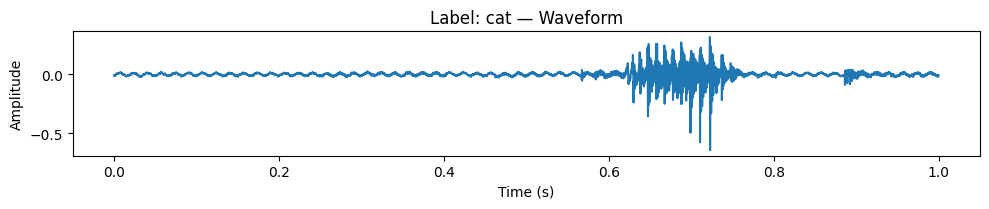

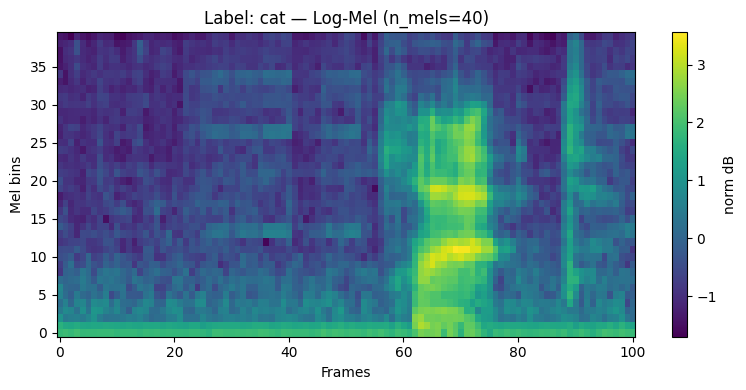

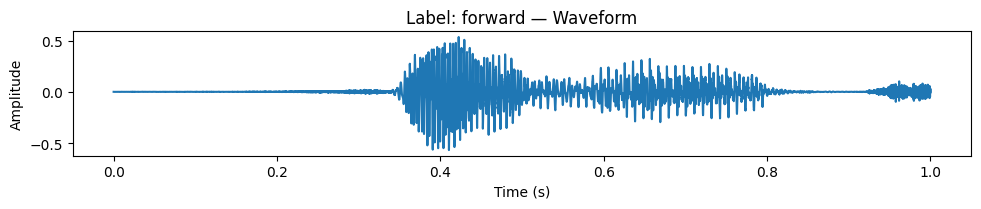

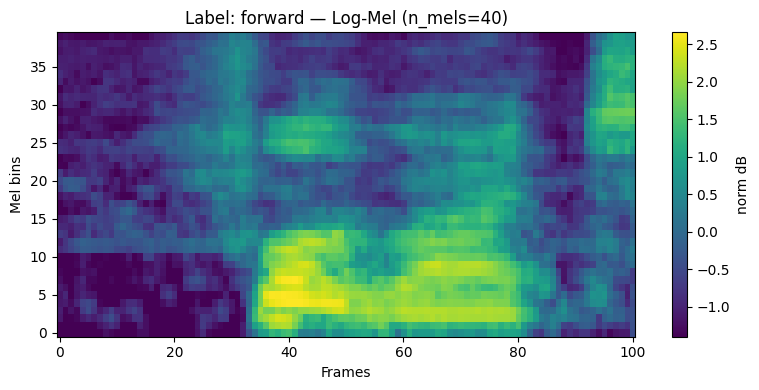

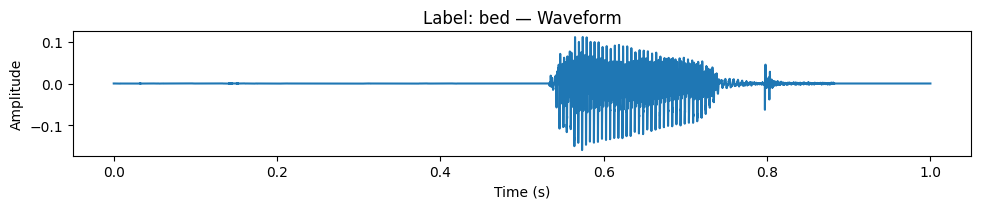

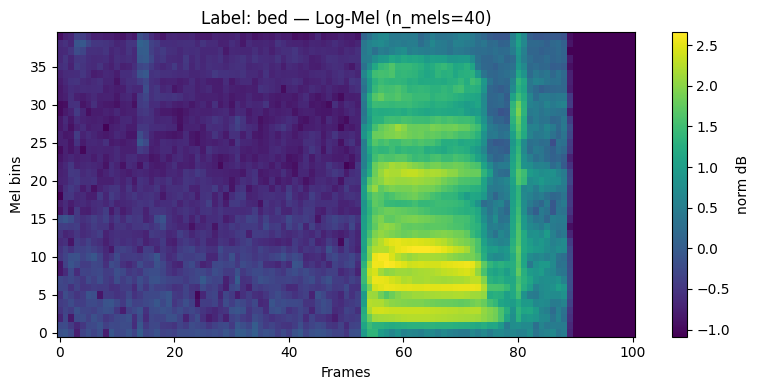

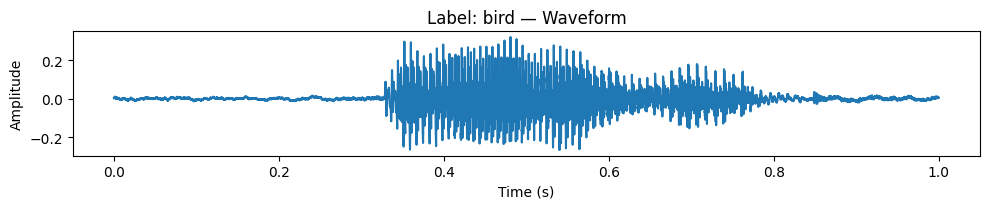

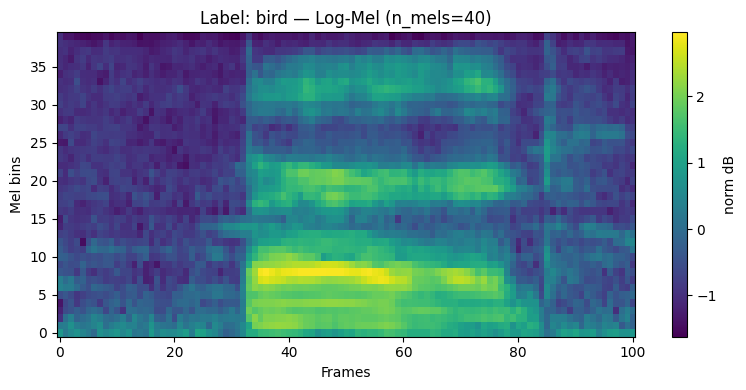

Saved clean previews to: /content/drive/MyDrive/NLP_Project/artifacts/previews


In [ ]:
# Creating two folders
PREVIEW_DIR = ARTIFACTS / "previews"; PREVIEW_DIR.mkdir(parents=True, exist_ok=True) # Clean waveform + spectrogram images
PREVIEW_AUG_DIR = ARTIFACTS / "previews_aug"; PREVIEW_AUG_DIR.mkdir(parents=True, exist_ok=True) # (reserved) augmented examples

# Plot helper (waveform + log-Mel)
def plot_waveform_and_logmel_base(wav: torch.Tensor, spec3: torch.Tensor, title: str, stem: str): # wav- raw 1-sec waveform [1, T] and spec3- 3-channel features [3, n_mels, time] (= log-Mel, Δ, ΔΔ)
    # Waveform time series (amplitude vs seconds)
    fig1 = plt.figure(figsize=(10, 2.2))
    x = np.arange(wav.shape[-1]) / CFG.sample_rate
    plt.title(f"{title} — Waveform")
    plt.plot(x, wav.squeeze(0).numpy())
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.tight_layout()
    fig1.savefig(PREVIEW_DIR / f"{stem}_waveform.png"); plt.show()

    # Log-Mel spectrogram — only channel 0 (base log-Mel), since it’s the most interpretable for viewers
    fig2 = plt.figure(figsize=(8, 4))
    plt.title(f"{title} — Log-Mel (n_mels={CFG.n_mels})")
    plt.imshow(spec3[0].numpy(), aspect="auto", origin="lower")
    plt.xlabel("Frames"); plt.ylabel("Mel bins"); plt.colorbar(label="norm dB")
    plt.tight_layout()
    fig2.savefig(PREVIEW_DIR / f"{stem}_logmel.png"); plt.show()

# sample files
sample_paths = []
if ALL_LABELS:
    labels_for_preview = sorted(ALL_LABELS)[:10]
    for lbl in random.sample(labels_for_preview, k=min(4, len(labels_for_preview))): # Randomly selects up to 4 audio files from the first 10 labels (to keep variety but avoid spamming).
        wavs = list((DATA_ROOT / lbl).rglob("*.wav"))
        if wavs: sample_paths.append(random.choice(wavs))

print(">>> PREVIEW FILES")

# Generate and save visuals
# Loads each WAV, pads/trims to exactly 1.0s @ 16 kHz.
#Builds 3-channel features with wav_to_logmel3(...), but turns off SpecAugment so the preview is clean and reproducible.
# Plots and saves the waveform and the base log-Mel images.
for p in sample_paths: print(" -", p)
for p in sample_paths:
    wav = pad_or_trim(load_wav(p))
    spec3 = wav_to_logmel3(wav, use_specaug=False)
    plot_waveform_and_logmel_base(wav, spec3, f"Label: {p.parent.name}", f"preview_{p.parent.name}_{p.stem}")
print("Saved clean previews to:", PREVIEW_DIR) # Tells where PNGs live (handy for Drive/GitHub upload).

>>> Augmentation previews:


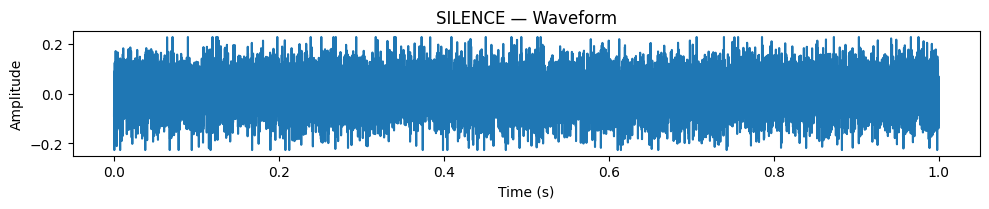

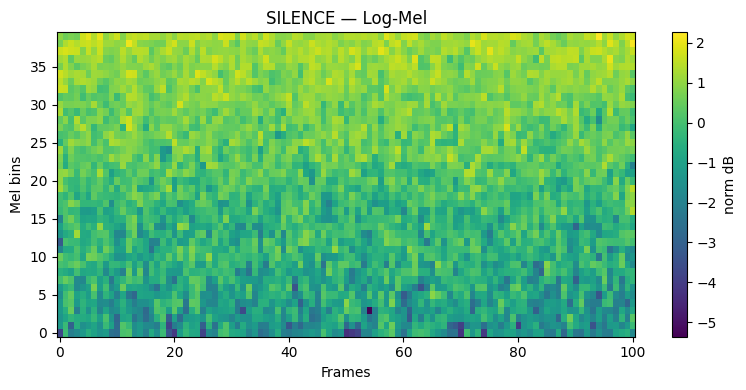

Saved augmented previews to: /content/drive/MyDrive/NLP_Project/artifacts/previews_aug


In [ ]:
def preview_aug_examples(n_examples=3):
    print(">>> Augmentation previews:")
    chosen = []
    labels_in_train = list({p.parent.name for p in LABEL_DIRS}) # Picking random training files
    random.shuffle(labels_in_train)
    for lbl in labels_in_train:
        cands = list((DATA_ROOT/lbl).rglob("*.wav"))
        if cands: chosen.append(random.choice(cands))
        if len(chosen) >= n_examples: break

    for p in chosen:  # Applying augmentation chain
        w_clean = pad_or_trim(load_wav(p)) # w_clean → original waveform (normalized, padded/truncated)
        
        #w_aug → runs through your full augmentation pipeline- Time shift (random ms shift), Random gain (volume scaling ± dB), Background noise mixing (with random SNR)
        w_aug   = add_background(random_gain(time_shift(w_clean, TIME_SHIFT_MS), *GAIN_DB_RANGE), snr_db_range=SNR_DB_RANGE)
        # Convert to spectrograms
        m_clean = wav_to_logmel3(w_clean, use_specaug=False) # clean log-Mel (no SpecAug).
        m_aug   = wav_to_logmel3(w_aug,   use_specaug=True) #noisy version + also applies SpecAugment (time/frequency masking).

        # save visuals (log-mel channel only)
        def save_pair(w, m, prefix):
            fig1 = plt.figure(figsize=(10, 2.2))
            x = np.arange(w.shape[-1]) / SAMPLE_RATE
            plt.title(f"{prefix} — Waveform"); plt.plot(x, w.squeeze(0).numpy())
            plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.tight_layout()
            fig1.savefig(PREVIEW_AUG_DIR / f"{prefix}_{p.parent.name}_{p.stem}_waveform.png"); plt.show()

            fig2 = plt.figure(figsize=(8, 4))
            plt.title(f"{prefix} — Log-Mel (40×T)")
            plt.imshow(m[0].numpy(), aspect="auto", origin="lower")
            plt.xlabel("Frames"); plt.ylabel("Mel bins"); plt.colorbar(label="norm dB")
            plt.tight_layout()
            fig2.savefig(PREVIEW_AUG_DIR / f"{prefix}_{p.parent.name}_{p.stem}_logmel.png"); plt.show()

        save_pair(w_clean, m_clean, "CLEAN")
        save_pair(w_aug,   m_aug,   "AUG")

    if INCLUDE_SILENCE: # Silence class preview
        w_sil = make_silence_waveform(); m_sil = wav_to_logmel3(w_sil, use_specaug=False)
        fig = plt.figure(figsize=(10, 2.2))
        x = np.arange(w_sil.shape[-1]) / SAMPLE_RATE
        plt.title("SILENCE — Waveform"); plt.plot(x, w_sil.squeeze(0).numpy())
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.tight_layout()
        fig.savefig(PREVIEW_AUG_DIR / "SILENCE_waveform.png"); plt.show()

        fig = plt.figure(figsize=(8, 4))
        plt.title("SILENCE — Log-Mel"); plt.imshow(m_sil[0].numpy(), aspect="auto", origin="lower")
        plt.xlabel("Frames"); plt.ylabel("Mel bins"); plt.colorbar(label="norm dB")
        plt.tight_layout(); plt.savefig(PREVIEW_AUG_DIR / "SILENCE_logmel.png"); plt.show()

preview_aug_examples(n_examples=3)
print("Saved augmented previews to:", PREVIEW_AUG_DIR)

## SPLITS, LABELS, DATASET, DATALOADERS — Split Builder

In [ ]:
# We will use official split files to split the data into training, validation and test sets
def build_splits():
    val_txt  = DATA_ROOT / "validation_list.txt" # official validation_list.txt
    test_txt = DATA_ROOT / "testing_list.txt" # official testing_list.txt
    def read_list(p: Path): return set(l.strip() for l in open(p) if l.strip())
    USE_OFFICIAL = val_txt.exists() and test_txt.exists()
    VAL_SET = read_list(val_txt) if USE_OFFICIAL else set()
    TEST_SET = read_list(test_txt) if USE_OFFICIAL else set()
    print("Using official splits:", USE_OFFICIAL)

    def rel(p: Path): return str(p.relative_to(DATA_ROOT)).replace("\\", "/")
    files_by_label = {lbl: sorted((DATA_ROOT / lbl).rglob("*.wav")) for lbl in ALL_LABELS} # Building a dictionary {label → list of wav files} for iteration.
    TRAIN, VAL, TEST = [], [], []
    if USE_OFFICIAL:
        for lbl, paths in files_by_label.items(): # Assigns files to Train/Val/Test
            for p in paths:
                r = rel(p)
                if r in VAL_SET: VAL.append(p)
                elif r in TEST_SET: TEST.append(p)
                else: TRAIN.append(p)
    else:
        for lbl, paths in files_by_label.items(): # Keeps class balance across splits (each label contributes ~10% to val and ~10% to test).
            paths = list(paths); random.shuffle(paths)
            n = len(paths); n_val = max(1, int(0.1*n)); n_test = max(1, int(0.1*n))
            VAL.extend(paths[:n_val]); TEST.extend(paths[n_val:n_val+n_test]); TRAIN.extend(paths[n_val+n_test:])
    return TRAIN, VAL, TEST

TRAIN, VAL, TEST = build_splits() # Each is a plain Python list of Path objects pointing to .wav files.
print("Split sizes -> train:", len(TRAIN), "| val:", len(VAL), "| test:", len(TEST)) # Quick sanity check so you can confirm the dataset sizes.

Using official splits: True
Split sizes -> train: 84843 | val: 9981 | test: 11005


In [ ]:
INCLUDE_UNKNOWN = False # if True, we'll add a special “catch-all” label for words outside your chosen commands.
UNKNOWN_LABEL   = "__unknown__"

# This is the official 20-command set defined in Google’s Speech Commands paper/dataset.Many models are trained only on these + silence + unknown. But we are using all the words
CORE_COMMANDS   = ["yes","no","up","down","left","right","on","off","stop","go",
                   "one","two","three","four","five","six","seven","eight","nine","zero"]

# Start with whatever labels you actually found in the dataset (ALL_LABELS is from your earlier directory scan)
FULL_LABELS = list(ALL_LABELS)
if INCLUDE_SILENCE and SILENCE_LABEL not in FULL_LABELS: FULL_LABELS.append(SILENCE_LABEL) # we configured silence examples earlier (make_silence_waveform()), add "__silence__" to the label list.
if INCLUDE_UNKNOWN and UNKNOWN_LABEL not in FULL_LABELS: FULL_LABELS.append(UNKNOWN_LABEL) # If we want to train an “other” class, add "__unknown__".

label2id = {lbl: i for i, lbl in enumerate(sorted(FULL_LABELS))} # turns a string label → numeric class index (e.g., "yes" → 0)
id2label = {i: lbl for lbl, i in label2id.items()} # inverse mapping (e.g., 0 → "yes")

# Sanity check
print(">>> LABEL SUMMARY")
print("Num labels:", len(FULL_LABELS))
print("First 15:", sorted(FULL_LABELS)[:15])

>>> LABEL SUMMARY
Num labels: 36
First 15: ['__silence__', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house']


In [ ]:
TRAIN, VAL, TEST = build_splits() # This function will return 3 sets
print("Split sizes -> train:", len(TRAIN), "| val:", len(VAL), "| test:", len(TEST))

Using official splits: True
Split sizes -> train: 84843 | val: 9981 | test: 11005


In [ ]:
# Custom Dataset- SpeechCommandsDataset
# Purpose- Turns your list of .wav file paths into model-ready tensors and labels.
# Output per sample: (spec3, label_id) where
# spec3 is a 3-channel feature tensor [3, 40, T] = [log-Mel, delta, delta²]
#label_id is the integer class index

class SpeechCommandsDataset(Dataset):
    """
    Returns (spec3: [3, 40, T], label_id: int)
    - Train: waveform augs + SpecAugment + optional silence injection
    - Val/Test: clean only
    """
    def __init__(self, paths, split, label2id,
                 silence_prob=0.10,
                 include_unknown=False, core_commands=None,
                 use_specaug=True):
        self.paths = list(paths)
        self.split = split
        self.label2id = label2id
        self.silence_prob = silence_prob if (split == "train" and INCLUDE_SILENCE) else 0.0
        self.include_unknown = include_unknown and (split == "train")
        self.core = set(core_commands or [])
        self.path_labels = [p.parent.name for p in self.paths]
        self.use_specaug = (use_specaug and split == "train")

    def __len__(self): return len(self.paths) # Returns the number of items (so DataLoader knows how many batches to create).

    def __getitem__(self, idx):
        # Inject synthetic silence with given probability
        if self.silence_prob > 0 and random.random() < self.silence_prob:
            wav = make_silence_waveform()
            spec3 = wav_to_logmel3(wav, use_specaug=False)
            y = self.label2id[SILENCE_LABEL]
            return spec3.float(), y

        path = self.paths[idx]
        lbl  = self.path_labels[idx]

        wav = pad_or_trim(load_wav(path)) # Load & standardize audio, load_wav → mono, resampled to 16 kHz, pad_or_trim → exactly TARGET_LEN samples (1 second)
        if self.split == "train":
            wav = time_shift(wav, TIME_SHIFT_MS) # onset jitter
            wav = random_gain(wav, *GAIN_DB_RANGE) # loudness jitter
            wav = add_background(wav, snr_db_range=SNR_DB_RANGE) # mix noise at target SNR

        # If use_specaug=True (train), applies time/frequency masks on the log-Mel to reduce overfitting.
        spec3 = wav_to_logmel3(wav, use_specaug=self.use_specaug) # Produces 3 channels: log-Mel, Δ, Δ² → shape [3, 40, T]

        if self.include_unknown and (lbl not in self.core): # Collapses any non-core label into the __unknown__ bucket (when enabled).
            lbl = UNKNOWN_LABEL
        if lbl not in self.label2id:
            raise KeyError(f"Unknown label: {lbl}")
        return spec3.float(), self.label2id[lbl] # Final tensor is float32; label is numeric id.

# Purpose: Batches variable-length time axes into a fixed-shape tensor.
# Input: batch is a list of (spec3, label_id) pairs.
# Find max time length T_max in the batch.
# Right-pad each spectrogram along time to T_max.
# Stack into X of shape [B, 3, 40, T_max]; labels into y of shape [B].
# Why needed? Even with fixed 1-second clips, tiny time differences can occur from transforms; padding ensures the whole batch forms a consistent tensor for the CNN.
def collate_fn(batch):
    xs, ys = zip(*batch)  # xs: [B, 3, 40, T_i]
    max_T = max(x.shape[-1] for x in xs)
    padded = []
    for x in xs:
        pad_T = max_T - x.shape[-1]
        if pad_T > 0: x = torch.nn.functional.pad(x, (0, pad_T))
        padded.append(x)
    X = torch.stack(padded, dim=0)  # [B, 3, 40, T]
    y = torch.tensor(ys, dtype=torch.long)
    return X, y

## Build Dataset objects

In [1]:
# Creating three datasets from path lists.
# split controls preprocessing:
# train: waveform augs (shift/gain/noise) + optional SpecAugment + optional silence injection (here silence_prob=0.10 → ~10% train items replaced by synthetic silence).
# val/test: clean only (no augs), use_specaug=False for fair evaluation.
# include_unknown / core_commands: (only relevant if you enabled an __unknown__ class) maps non-core labels to __unknown__ during training.
# label2id: string label → integer id mapping used by the loss.

train_ds = SpeechCommandsDataset(TRAIN, split="train", label2id=label2id,
                                 silence_prob=0.10, include_unknown=INCLUDE_UNKNOWN,
                                 core_commands=CORE_COMMANDS, use_specaug=USE_SPEC_AUG)
val_ds   = SpeechCommandsDataset(VAL, split="val", label2id=label2id, use_specaug=False)
test_ds  = SpeechCommandsDataset(TEST, split="test", label2id=label2id, use_specaug=False)


# Wrap in DataLoaders
#batch_size=BATCH_SIZE: how many examples per GPU step (trades off speed vs memory).
#shuffle=True (train only): mixes training examples each epoch to reduce overfitting.
#num_workers=NUM_WORKERS: how many CPU workers load/augment data in parallel (2 on GPU is a good Colab default; set to 0 if you prefer no multiprocessing).
#pin_memory=True: speeds up CPU→GPU transfer.
#collate_fn=collate_fn: pads time dimension in-batch so tensors stack cleanly to [B, 3, 40, T_max].

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)

print(">>> DATALOADERS READY")
print("BATCH_SIZE:", BATCH_SIZE, "| NUM_WORKERS:", NUM_WORKERS)
print("Sizes -> train:", len(train_ds), "| val:", len(val_ds), "| test:", len(test_ds))

# ignore this error because I bymistakly ran this cell after completing the notbook

NameError: name 'SpeechCommandsDataset' is not defined

In [ ]:
# Quick batch sanity
train_X, train_y = next(iter(train_loader))
val_X,   val_y   = next(iter(val_loader))
print("\n>>> TRAIN BATCH")
print("X:", tuple(train_X.shape), "| y:", tuple(train_y.shape))
print("First 10 labels (id->name):", [f"{int(i)}->{id2label[int(i)]}" for i in train_y[:10]])
print("\n>>> VAL BATCH")
print("X:", tuple(val_X.shape), "| y:", tuple(val_y.shape))


>>> TRAIN BATCH
X: (128, 3, 40, 101) | y: (128,)
First 10 labels (id->name): ['21->on', '31->up', '0->__silence__', '34->yes', '19->no', '31->up', '34->yes', '14->house', '24->seven', '16->left']

>>> VAL BATCH
X: (128, 3, 40, 101) | y: (128,)


## MODEL (DS-CNN, in_ch=3, base_ch=48)

### DepthwiseSeparableConv

**A lightweight CNN block popularized by MobileNet. It splits a standard 3×3 convolution into:**
* Depthwise conv `(groups=in_ch)`: one 3×3 filter per input channel → captures local patterns within each channel separately, very cheap.
* Pointwise conv (1×1): mixes information across channels to form new feature maps.

**Why:**
It gives you most of the representational power of a normal conv but with far fewer parameters and FLOPs, which is great for real-time KWS.

**Parts inside:**
* `self.dw`: 3×3 depthwise conv (possibly with stride to downsample in time/freq).
* `self.dwbn`: BatchNorm to stabilize/accelerate training.
* `self.pw`: 1×1 pointwise conv to recombine channels.
* `self.pwbn`: BatchNorm again.
* `self.drop`: optional Dropout for regularization.
* `Forward`: ReLU after each BN, then optional dropout.

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.0):
        super().__init__()
        self.dw   = nn.Conv2d(in_ch, in_ch, 3, stride=stride, padding=1, groups=in_ch, bias=False)
        self.dwbn = nn.BatchNorm2d(in_ch)
        self.pw   = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.pwbn = nn.BatchNorm2d(out_ch)
        self.drop = nn.Dropout(p_drop) if p_drop > 0 else nn.Identity()
    def forward(self, x):
        x = F.relu(self.dwbn(self.dw(x)), inplace=True)
        x = F.relu(self.pwbn(self.pw(x)), inplace=True)
        return self.drop(x)

## DS-CNN head (full network)

Input tensor: [B, 3, 40, T]
* 3 channels = log-Mel, delta, delta² (your “3-channel feature” choice)
* 40 = Mel bins
* T = time frames

Output: [B, num_classes] raw class logits.

In [ ]:
class DSCNN_KWS(nn.Module):
    """Input: [B,3,40,T] -> logits [B,num_classes]"""
    def __init__(self, num_classes: int, in_ch: int = IN_CH, base_ch: int = BASE_CH, p_drop: float = 0.10):
        super().__init__()
        self.stem = nn.Sequential( # A standard 3×3 conv to “lift” 3 input channels up to base_ch (here 48), creating a richer feature space.
            nn.Conv2d(in_ch, base_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )
        ch = base_ch
        self.block1 = DepthwiseSeparableConv(ch,   ch,   stride=1, p_drop=p_drop) # keep resolution
        self.block2 = DepthwiseSeparableConv(ch,   ch*2, stride=2, p_drop=p_drop); ch *= 2 # downsample, double channels
        self.block3 = DepthwiseSeparableConv(ch,   ch,   stride=1, p_drop=p_drop) # keep resolution
        self.block4 = DepthwiseSeparableConv(ch,   ch*2, stride=2, p_drop=p_drop); ch *= 2 # downsample, double channels
        '''Stride=2 in blocks 2 and 4 reduces the time/frequency resolution while increasing channels (feature depth).
        This is a standard compute-efficient way to grow representational capacity: fewer, richer spatial positions.'''
        # Final BN + ReLU + Dropout → Global Average Pooling → Linear classifier
        self.head_bn = nn.BatchNorm2d(ch)
        self.head_dp = nn.Dropout(p_drop)
        self.fc = nn.Linear(ch, num_classes)

    # Global Average Pooling collapses the 2D feature map into a single vector per sample (no fully-connected spatial layers), keeping params small and improving generalization.
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x); x = self.block2(x)
        x = self.block3(x); x = self.block4(x)
        x = F.relu(self.head_bn(x), inplace=True)
        x = self.head_dp(x)
        x = x.mean(dim=(-2, -1))  # global avg pool over (freq,time)
        return self.fc(x)

num_classes = len(label2id)
model = DSCNN_KWS(num_classes=num_classes).to(device) # Uses your label mapping to set the classifier size and moves the model to GPU if available.

## Parameter count (sanity + model size)

* `p.numel()` counts how many scalars are in each tensor.
* `total_params` = all parameters (weights + biases).
* `trainable_params` = parameters that will receive gradients (usually all of them unless you froze layers).
* Why: lets you report model capacity and compare sizes across experiments.

* `next(iter(train_loader))` pulls one batch from your training data.
* `[0]` selects the inputs (X) from `(X, y)`.
* `.to(device, non_blocking=True)` moves the batch to GPU (if available) efficiently.
* `torch.no_grad()` disables gradient tracking for this quick check (faster, less memory).
* `logits = model(train_batch)` runs a single forward pass to verify:
- The model accepts tensors of shape `[B, 3, 40, T]` (your 3-channel spectrograms).
- The output has shape `[B, num_classes]`, as expected.
* Why: catches shape mismatches before you start training; also confirms the full input→output pipeline

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(">>> MODEL SUMMARY")
print(f"DS-CNN base_ch={BASE_CH} | in_ch={IN_CH} | classes={num_classes} | params={total_params:,} (trainable={trainable_params:,})")

train_batch = next(iter(train_loader))[0].to(device, non_blocking=True)
with torch.no_grad():
    logits = model(train_batch)
print("Dry run shapes -> input:", tuple(train_batch.shape), "| logits:", tuple(logits.shape))

>>> MODEL SUMMARY
DS-CNN base_ch=48 | in_ch=3 | classes=36 | params=47,316 (trainable=47,316)
Dry run shapes -> input: (128, 3, 40, 101) | logits: (128, 36)


## METRICS, PLOTS & CHECKPOINTS

In [ ]:
# Import scikit-learn metrics (with auto-install fallback)
try:
    import sklearn
    from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scikit-learn"])
    from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Creating directories to save checkpoints and export plots (loss/acc curves, CM, ROC, etc.).
CKPT_DIR  = ARTIFACTS / "checkpoints"
PLOTS_DIR = ARTIFACTS / "plots"
for d in [CKPT_DIR, PLOTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Converts model logits → probabilities along the class axis.
def softmax_logits(logits: torch.Tensor) -> torch.Tensor:
    return torch.softmax(logits, dim=1)

* Turns off gradients (faster, less memory) and switches model to eval mode (BN/Dropout behave correctly).

For each batch:
* Moves `X, y` to device.
* Runs a forward pass to get `ogits`.
* Computes cross-entropy loss (note: evaluation uses standard CE; training may use label smoothing).
* Applies softmax to get probabilities `proba`.
* Gets predictions via `argmax`.

* Accumulates:
* `total_loss` (sum of batch losses × batch size)
* `total_correct` (for accuracy)
* Raw arrays for `y_true`, `y_pred`, `y_proba` (used later for F1, CM, ROC, reports).

* At the end:
* Accuracy = fraction correct over all examples
* Macro F1 = unweighted mean F1 across classes (treats each class equally)
* Returns a dict:
`{"loss", "acc", "macro_f1", "y_true", "y_pred", "y_proba"}`

Why this design?
* One function that works for train/val/test loaders → consistent metric computation.
* Returns both summary metrics (loss/acc/F1) and full arrays for downstream plots and reports.

In [ ]:
# Unified evaluation loop
@torch.no_grad()
def evaluate(model, loader: DataLoader, device, num_classes: int) -> Dict[str, float]:
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    all_targets, all_preds, all_proba = [], [], []
    for X, y in loader:
        X = X.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        logits = model(X)
        loss = F.cross_entropy(logits, y)  # eval loss without smoothing is fine
        proba = softmax_logits(logits)
        pred = torch.argmax(proba, dim=1)

        total_loss += loss.item() * X.size(0)
        total_correct += (pred == y).sum().item()
        total_count  += X.size(0)

        all_targets.append(y.detach().cpu().numpy())
        all_preds.append(pred.detach().cpu().numpy())
        all_proba.append(proba.detach().cpu().numpy())

    y_true = np.concatenate(all_targets, axis=0) if all_targets else np.array([])
    y_pred = np.concatenate(all_preds, axis=0) if all_preds else np.array([])
    y_proba = np.concatenate(all_proba, axis=0) if all_proba else np.zeros((0, num_classes), dtype=np.float32)

    acc = (y_pred == y_true).mean() if y_true.size else 0.0
    macro_f1 = f1_score(y_true, y_pred, average="macro") if y_true.size else 0.0
    return {"loss": total_loss / max(total_count, 1), "acc": acc, "macro_f1": macro_f1,
            "y_true": y_true, "y_pred": y_pred, "y_proba": y_proba}

In [ ]:
# Plot training/validation/test curves (loss, accuracy, macro F1)
def plot_curves(history: List[Dict[str, float]], save_dir: Path): 
    epochs = np.arange(1, len(history)+1)
    def _s(key): return [h[key] for h in history]

    plt.figure(figsize=(8,4)); plt.title("Loss per epoch")
    plt.plot(epochs, _s("train_loss"), label="train")
    plt.plot(epochs, _s("val_loss"),   label="val")
    plt.plot(epochs, _s("test_loss"),  label="test")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
    plt.savefig(save_dir / "curve_loss.png"); plt.show()

    plt.figure(figsize=(8,4)); plt.title("Accuracy per epoch")
    plt.plot(epochs, _s("train_acc"), label="train")
    plt.plot(epochs, _s("val_acc"),   label="val")
    plt.plot(epochs, _s("test_acc"),  label="test")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.tight_layout()
    plt.savefig(save_dir / "curve_accuracy.png"); plt.show()

    plt.figure(figsize=(8,4)); plt.title("Macro F1 per epoch")
    plt.plot(epochs, _s("train_f1"), label="train")
    plt.plot(epochs, _s("val_f1"),   label="val")
    plt.plot(epochs, _s("test_f1"),  label="test")
    plt.xlabel("epoch"); plt.ylabel("macro F1"); plt.legend(); plt.tight_layout()
    plt.savefig(save_dir / "curve_macro_f1.png"); plt.show()

# Plot confusion matrix (optionally normalized)
def plot_confusion(y_true, y_pred, labels: List[str], save_path: Path, normalize=True):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    if normalize:
        cm = cm.astype(np.float64)
        row_sums = cm.sum(axis=1, keepdims=True) + 1e-12
        cm = cm / row_sums
    plt.figure(figsize=(10, 8)); plt.title("Confusion Matrix" + (" (normalized)" if normalize else ""))
    im = plt.imshow(cm, aspect="auto", origin="upper"); plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_idx = np.arange(len(labels))
    plt.xticks(tick_idx, [labels[i] for i in tick_idx], rotation=90)
    plt.yticks(tick_idx, [labels[i] for i in tick_idx])
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.savefig(save_path); plt.show()

# Plot per-class F1 scores (sorted)
def plot_per_class_f1(y_true, y_pred, labels: List[str], save_path: Path):
    f1s = []
    for i in range(len(labels)):
        mask_true = (y_true == i).astype(np.int32)
        mask_pred = (y_pred == i).astype(np.int32)
        f1s.append(f1_score(mask_true, mask_pred, zero_division=0))
    f1s = np.array(f1s)
    order = np.argsort(-f1s)
    plt.figure(figsize=(10, 5)); plt.title("Per-class F1 (sorted)")
    plt.bar(np.arange(len(labels)), f1s[order])
    plt.xticks(np.arange(len(labels)), [labels[i] for i in order], rotation=90)
    plt.ylabel("F1"); plt.tight_layout(); plt.savefig(save_path); plt.show()

# Plot ROC curves (one-vs-rest, macro AUC)
def plot_roc_ovr(y_true, y_proba, save_path: Path, labels: List[str]):
    try:
        auc_macro = roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro")
    except ValueError:
        auc_macro = float("nan")
    plt.figure(figsize=(7,5)); plt.title(f"ROC AUC (macro-OVR) = {auc_macro:.3f}")
    classes_to_plot = list(range(min(6, y_proba.shape[1])))
    for c in classes_to_plot:
        y_bin = (y_true == c).astype(np.int32)
        fpr, tpr, _ = roc_curve(y_bin, y_proba[:, c])
        plt.plot(fpr, tpr, label=f"{labels[c]}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout()
    plt.savefig(save_path); plt.show()

# Save model & optimizer state checkpoint
def save_checkpoint(model, optimizer, epoch, best_val_f1, path: Path):
    torch.save({"model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "epoch": epoch,
                "best_val_f1": best_val_f1,
                "label2id": label2id}, path)
    
# Save metrics history as CSV
def save_metrics_csv(history: List[Dict[str, float]], save_path: Path):
    keys = ["epoch","train_loss","val_loss","test_loss","train_acc","val_acc","test_acc",
            "train_f1","val_f1","test_f1","lr"]
    with open(save_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=keys); w.writeheader()
        for h in history: w.writerow({k: h.get(k, "") for k in keys})

## Training Loop

In [ ]:
# Uses cross-entropy but softens the one-hot targets by 5%. This reduces over-confidence and usually improves generalization.
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH) 

# AdamW is Adam + decoupled L2 regularization. Weight decay helps prevent overfitting.
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Gradually lowers the LR following a cosine curve over 20 steps (epochs here), never going below 1e-5
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

# We'll append a dict each epoch (loss/acc/F1/LR) for train/val/test; later used by plot_curves
history = []
best_val_f1 = -1.0
best_ckpt = CKPT_DIR / "best_by_val_f1.pt" # Keeps the best validation F1 seen so far and the path to save that checkpoint.

In [ ]:
# Resume (optional)
start_epoch = 1 # Default start epoch, Assume a fresh run unless a checkpoint is found.
if best_ckpt.exists(): # Reads the saved file best_by_val_f1.pt (if it exists).
    ckpt = torch.load(best_ckpt, map_location=device)
    try:
        # Puts the model weights and optimizer (including LR, moments) back to where training last saved.
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        
        # Keeps your “best so far” metric, resumes from the next epoch after the saved one.
        best_val_f1 = ckpt.get("best_val_f1", best_val_f1)
        start_epoch  = ckpt.get("epoch", 0) + 1
        print(f"[Resume] Loaded checkpoint: epoch {ckpt.get('epoch','?')} | best val F1={best_val_f1:.4f}")
        
    except Exception as e: # If shapes/keys don’t match (e.g., you changed architecture), training starts from scratch.
        print("[Resume] Could not load checkpoint, starting fresh. Reason:", e)

# Echoes key knobs so logs clearly document the resume point and hyperparameters.
print(f"Starting at epoch {start_epoch}/{EPOCHS} | USE_SPEC_AUG={USE_SPEC_AUG} | base_ch={BASE_CH} | in_ch={IN_CH} | label_smoothing={LABEL_SMOOTH}")

Starting at epoch 1/35 | USE_SPEC_AUG=True | base_ch=48 | in_ch=3 | label_smoothing=0.05


In [ ]:
for epoch in range(start_epoch, EPOCHS + 1): # Iterates through training epochs, starting from a resume point if applicable.
    # Enables training mode (dropout, BN updates) and initializes counters for tracking loss & accuracy.
    model.train()
    running_loss, running_correct, running_count = 0.0, 0, 0

    # Iterates over train_loader, Forward pass → loss calculation → backward pass, Clips gradients to avoid exploding gradients, Updates model parameters.
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False)
    for X, y in pbar:
        X = X.to(device, non_blocking=True); y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
        optimizer.step()

        with torch.no_grad(): # Collects cumulative training loss and accuracy and updates progress bar (tqdm) with live metrics.
            pred = torch.argmax(logits, dim=1)
            running_loss   += loss.item() * X.size(0)
            running_correct += (pred == y).sum().item()
            running_count  += X.size(0)
            pbar.set_postfix(loss=running_loss/max(running_count,1),
                             acc=running_correct/max(running_count,1))

    # Averages training metrics over the entire epoch.
    train_loss = running_loss / max(running_count, 1)
    train_acc  = running_correct / max(running_count, 1)

    # Validation & Test Evaluation
    val_metrics  = evaluate(model, val_loader,  device, num_classes)
    test_metrics = evaluate(model, test_loader, device, num_classes) if EVAL_TEST_EVERY_EPOCH else \
                   {"loss": np.nan, "acc": np.nan, "macro_f1": np.nan}

    # Updates learning rate (Cosine Annealing in your case) and tracks the current learning rate.
    if scheduler is not None: scheduler.step()
    last_lr = optimizer.param_groups[0]["lr"]

    # Train F1 (pass with workers=0)
    train_metrics_for_f1 = evaluate(
        model,
        DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn),
        device, num_classes
    )
    train_f1 = train_metrics_for_f1["macro_f1"]

    # Log Metrics
    row = {"epoch": epoch, "train_loss": train_loss, "val_loss": val_metrics["loss"], "test_loss": test_metrics["loss"],
           "train_acc": train_acc, "val_acc": val_metrics["acc"], "test_acc": test_metrics["acc"],
           "train_f1": train_f1, "val_f1": val_metrics["macro_f1"], "test_f1": test_metrics["macro_f1"], "lr": last_lr}
    history.append(row)

    print(f"\n[Epoch {epoch:02d}] " # Displays nicely formatted progress log.
          f"Train: loss={train_loss:.4f} acc={train_acc:.4f} F1={train_f1:.4f} | "
          f"Val: loss={val_metrics['loss']:.4f} acc={val_metrics['acc']:.4f} F1={val_metrics['macro_f1']:.4f} | "
          f"Test: loss={test_metrics['loss']:.4f} acc={test_metrics['acc']:.4f} F1={test_metrics['macro_f1']:.4f} | "
          f"LR={last_lr:.2e}")

    if val_metrics["macro_f1"] > best_val_f1: # Saves checkpoint if current validation F1 is the best so far.
        best_val_f1 = val_metrics["macro_f1"]
        save_checkpoint(model, optimizer, epoch, best_val_f1, best_ckpt)
        print(f"  ↳ New best val F1: {best_val_f1:.4f} (checkpoint saved)")

# After training finishes, all metrics across epochs are exported to CSV.
metrics_csv = ARTIFACTS / "metrics.csv"
save_metrics_csv(history, metrics_csv)
print("Saved metrics to:", metrics_csv)

Epoch 1/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 01] Train: loss=2.9328 acc=0.2198 F1=0.1745 | Val: loss=2.6944 acc=0.2276 F1=0.1569 | Test: loss=2.7683 acc=0.2193 F1=0.1511 | LR=9.94e-04
  ↳ New best val F1: 0.1569 (checkpoint saved)


Epoch 2/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 02] Train: loss=2.1917 acc=0.4449 F1=0.4464 | Val: loss=1.3217 acc=0.6469 F1=0.5727 | Test: loss=1.4093 acc=0.6264 F1=0.5497 | LR=9.76e-04
  ↳ New best val F1: 0.5727 (checkpoint saved)


Epoch 3/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 03] Train: loss=1.7540 acc=0.5815 F1=0.5689 | Val: loss=0.8473 acc=0.7765 F1=0.7202 | Test: loss=0.9265 acc=0.7492 F1=0.6930 | LR=9.46e-04
  ↳ New best val F1: 0.7202 (checkpoint saved)


Epoch 4/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 04] Train: loss=1.5449 acc=0.6442 F1=0.6199 | Val: loss=0.7114 acc=0.7985 F1=0.7540 | Test: loss=0.7895 acc=0.7761 F1=0.7294 | LR=9.05e-04
  ↳ New best val F1: 0.7540 (checkpoint saved)


Epoch 5/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 05] Train: loss=1.4316 acc=0.6806 F1=0.6613 | Val: loss=0.5906 acc=0.8397 F1=0.7957 | Test: loss=0.6645 acc=0.8155 F1=0.7699 | LR=8.55e-04
  ↳ New best val F1: 0.7957 (checkpoint saved)


Epoch 6/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 06] Train: loss=1.3507 acc=0.7070 F1=0.6908 | Val: loss=0.5613 acc=0.8505 F1=0.8158 | Test: loss=0.6243 acc=0.8322 F1=0.7975 | LR=7.96e-04
  ↳ New best val F1: 0.8158 (checkpoint saved)


Epoch 7/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 07] Train: loss=1.3018 acc=0.7236 F1=0.7146 | Val: loss=0.5054 acc=0.8690 F1=0.8382 | Test: loss=0.5726 acc=0.8466 F1=0.8149 | LR=7.30e-04
  ↳ New best val F1: 0.8382 (checkpoint saved)


Epoch 8/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 08] Train: loss=1.2616 acc=0.7364 F1=0.7176 | Val: loss=0.4942 acc=0.8694 F1=0.8377 | Test: loss=0.5644 acc=0.8501 F1=0.8150 | LR=6.58e-04


Epoch 9/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 09] Train: loss=1.2236 acc=0.7503 F1=0.7391 | Val: loss=0.4449 acc=0.8827 F1=0.8524 | Test: loss=0.4979 acc=0.8674 F1=0.8358 | LR=5.82e-04
  ↳ New best val F1: 0.8524 (checkpoint saved)


Epoch 10/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 10] Train: loss=1.2007 acc=0.7568 F1=0.7484 | Val: loss=0.4203 acc=0.8899 F1=0.8606 | Test: loss=0.4728 acc=0.8732 F1=0.8408 | LR=5.05e-04
  ↳ New best val F1: 0.8606 (checkpoint saved)


Epoch 11/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 11] Train: loss=1.1791 acc=0.7648 F1=0.7604 | Val: loss=0.4091 acc=0.8929 F1=0.8644 | Test: loss=0.4613 acc=0.8769 F1=0.8462 | LR=4.28e-04
  ↳ New best val F1: 0.8644 (checkpoint saved)


Epoch 12/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb105d97c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb105d97c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


[Epoch 12] Train: loss=1.1611 acc=0.7712 F1=0.7592 | Val: loss=0.4000 acc=0.8913 F1=0.8626 | Test: loss=0.4458 acc=0.8751 F1=0.8435 | LR=3.52e-04


Epoch 13/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 13] Train: loss=1.1520 acc=0.7731 F1=0.7690 | Val: loss=0.3934 acc=0.8973 F1=0.8701 | Test: loss=0.4356 acc=0.8840 F1=0.8542 | LR=2.80e-04
  ↳ New best val F1: 0.8701 (checkpoint saved)


Epoch 14/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 14] Train: loss=1.1357 acc=0.7792 F1=0.7758 | Val: loss=0.3864 acc=0.8960 F1=0.8687 | Test: loss=0.4316 acc=0.8817 F1=0.8514 | LR=2.14e-04


Epoch 15/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 15] Train: loss=1.1237 acc=0.7829 F1=0.7779 | Val: loss=0.3823 acc=0.8986 F1=0.8704 | Test: loss=0.4238 acc=0.8876 F1=0.8568 | LR=1.55e-04
  ↳ New best val F1: 0.8704 (checkpoint saved)


Epoch 16/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 16] Train: loss=1.1193 acc=0.7839 F1=0.7804 | Val: loss=0.3646 acc=0.9053 F1=0.8766 | Test: loss=0.4012 acc=0.8936 F1=0.8628 | LR=1.05e-04
  ↳ New best val F1: 0.8766 (checkpoint saved)


Epoch 17/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 17] Train: loss=1.1162 acc=0.7859 F1=0.7794 | Val: loss=0.3689 acc=0.9040 F1=0.8749 | Test: loss=0.4079 acc=0.8911 F1=0.8604 | LR=6.40e-05


Epoch 18/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 18] Train: loss=1.1096 acc=0.7878 F1=0.7804 | Val: loss=0.3637 acc=0.9046 F1=0.8759 | Test: loss=0.4045 acc=0.8934 F1=0.8638 | LR=3.42e-05


Epoch 19/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 19] Train: loss=1.1100 acc=0.7856 F1=0.7835 | Val: loss=0.3769 acc=0.9020 F1=0.8752 | Test: loss=0.4161 acc=0.8900 F1=0.8613 | LR=1.61e-05


Epoch 20/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 20] Train: loss=1.1069 acc=0.7870 F1=0.7861 | Val: loss=0.3638 acc=0.9064 F1=0.8782 | Test: loss=0.4031 acc=0.8939 F1=0.8634 | LR=1.00e-05
  ↳ New best val F1: 0.8782 (checkpoint saved)


Epoch 21/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 21] Train: loss=1.1023 acc=0.7899 F1=0.7844 | Val: loss=0.3753 acc=0.9025 F1=0.8747 | Test: loss=0.4146 acc=0.8907 F1=0.8619 | LR=1.61e-05


Epoch 22/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 22] Train: loss=1.0986 acc=0.7899 F1=0.7845 | Val: loss=0.3673 acc=0.9046 F1=0.8770 | Test: loss=0.4067 acc=0.8916 F1=0.8623 | LR=3.42e-05


Epoch 23/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 23] Train: loss=1.0984 acc=0.7917 F1=0.7832 | Val: loss=0.3624 acc=0.9061 F1=0.8775 | Test: loss=0.4010 acc=0.8933 F1=0.8630 | LR=6.40e-05


Epoch 24/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 24] Train: loss=1.1063 acc=0.7875 F1=0.7815 | Val: loss=0.3669 acc=0.9041 F1=0.8759 | Test: loss=0.4071 acc=0.8920 F1=0.8620 | LR=1.05e-04


Epoch 25/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 25] Train: loss=1.1037 acc=0.7880 F1=0.7855 | Val: loss=0.3626 acc=0.9065 F1=0.8775 | Test: loss=0.4026 acc=0.8942 F1=0.8636 | LR=1.55e-04


Epoch 26/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 26] Train: loss=1.1021 acc=0.7905 F1=0.7849 | Val: loss=0.3618 acc=0.9064 F1=0.8789 | Test: loss=0.4055 acc=0.8916 F1=0.8630 | LR=2.14e-04
  ↳ New best val F1: 0.8789 (checkpoint saved)


Epoch 27/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb105d97c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb105d97c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


[Epoch 27] Train: loss=1.1067 acc=0.7896 F1=0.7847 | Val: loss=0.3536 acc=0.9083 F1=0.8793 | Test: loss=0.3952 acc=0.8944 F1=0.8629 | LR=2.80e-04
  ↳ New best val F1: 0.8793 (checkpoint saved)


Epoch 28/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 28] Train: loss=1.1065 acc=0.7879 F1=0.7833 | Val: loss=0.3486 acc=0.9103 F1=0.8829 | Test: loss=0.3874 acc=0.8985 F1=0.8698 | LR=3.52e-04
  ↳ New best val F1: 0.8829 (checkpoint saved)


Epoch 29/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb105d97c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb105d97c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


[Epoch 29] Train: loss=1.1039 acc=0.7881 F1=0.7817 | Val: loss=0.3768 acc=0.8995 F1=0.8721 | Test: loss=0.4161 acc=0.8891 F1=0.8599 | LR=4.28e-04


Epoch 30/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 30] Train: loss=1.1025 acc=0.7886 F1=0.7859 | Val: loss=0.3607 acc=0.9034 F1=0.8783 | Test: loss=0.3951 acc=0.8956 F1=0.8688 | LR=5.05e-04


Epoch 31/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 31] Train: loss=1.1050 acc=0.7882 F1=0.7873 | Val: loss=0.3319 acc=0.9131 F1=0.8827 | Test: loss=0.3599 acc=0.9028 F1=0.8709 | LR=5.82e-04


Epoch 32/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 32] Train: loss=1.1019 acc=0.7905 F1=0.7827 | Val: loss=0.3784 acc=0.8957 F1=0.8720 | Test: loss=0.4243 acc=0.8881 F1=0.8635 | LR=6.58e-04


Epoch 33/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 33] Train: loss=1.0962 acc=0.7899 F1=0.7885 | Val: loss=0.3318 acc=0.9129 F1=0.8843 | Test: loss=0.3720 acc=0.9002 F1=0.8698 | LR=7.30e-04
  ↳ New best val F1: 0.8843 (checkpoint saved)


Epoch 34/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 34] Train: loss=1.0957 acc=0.7913 F1=0.7917 | Val: loss=0.3379 acc=0.9142 F1=0.8874 | Test: loss=0.3776 acc=0.9014 F1=0.8728 | LR=7.96e-04
  ↳ New best val F1: 0.8874 (checkpoint saved)


Epoch 35/35 [train]:   0%|          | 0/663 [00:00<?, ?it/s]


[Epoch 35] Train: loss=1.0904 acc=0.7926 F1=0.7869 | Val: loss=0.3530 acc=0.9074 F1=0.8785 | Test: loss=0.3820 acc=0.8985 F1=0.8687 | LR=8.55e-04
Saved metrics to: /content/drive/MyDrive/NLP_Project/artifacts/metrics.csv


## Plots and Final Evalution

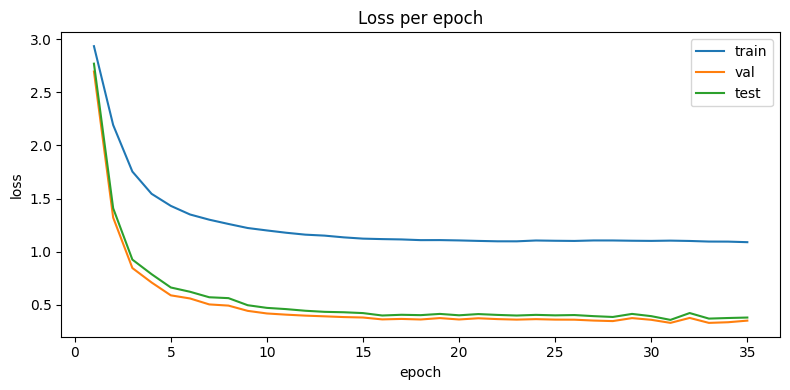

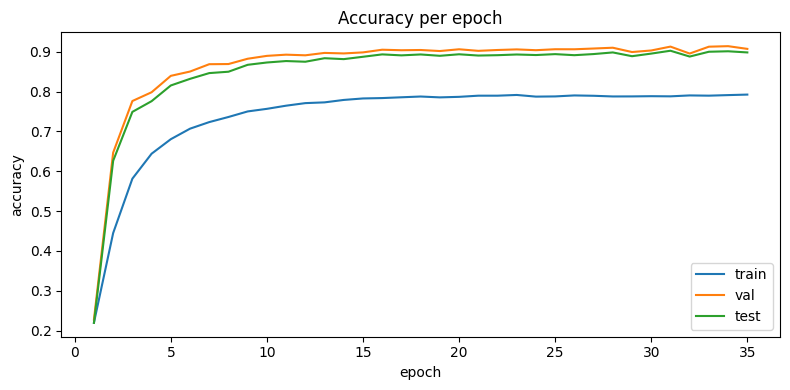

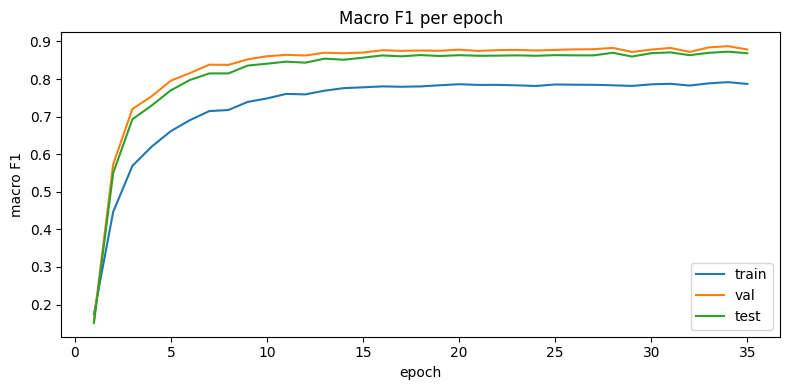

Saved epoch curves to: /content/drive/MyDrive/NLP_Project/artifacts/plots


In [ ]:
plot_curves(history, PLOTS_DIR)
print("Saved epoch curves to:", PLOTS_DIR)

In [ ]:
ckpt = torch.load(best_ckpt, map_location=device)
model.load_state_dict(ckpt["model_state"])
print(f"Loaded best checkpoint from epoch {ckpt['epoch']} (val F1={ckpt['best_val_f1']:.4f})")

Loaded best checkpoint from epoch 34 (val F1=0.8874)


In [ ]:
test_metrics = evaluate(model, test_loader, device, num_classes) # Calls earlier evaluate() function and returns a dictionary with keys.

# y_true: ground-truth test labels (numpy array, shape [N])
# y_pred: predicted labels (numpy array, shape [N])
# y_proba: predicted probabilities for all classes (numpy array, shape [N, num_classes])

y_true, y_pred, y_proba = test_metrics["y_true"], test_metrics["y_pred"], test_metrics["y_proba"]

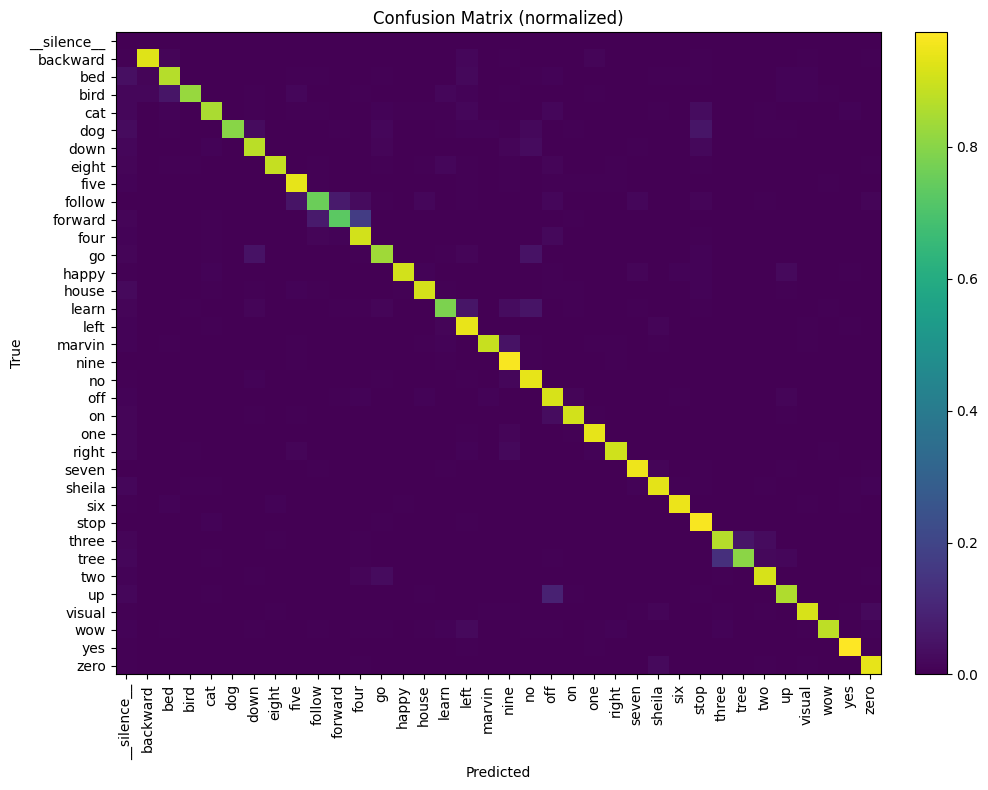

In [ ]:
cm_path = PLOTS_DIR / "confusion_matrix_test.png"
plot_confusion(y_true, y_pred, [id2label[i] for i in range(num_classes)], cm_path)

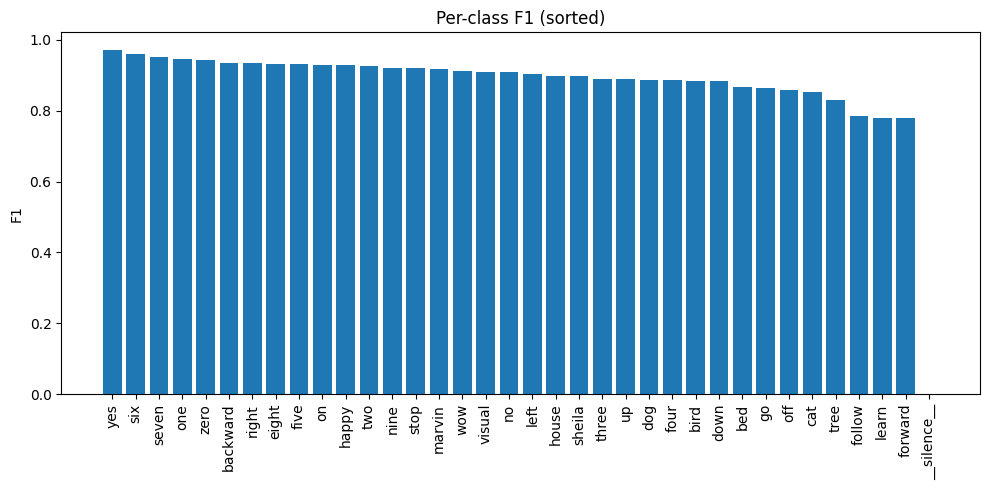

In [ ]:
f1_bar_path = PLOTS_DIR / "per_class_f1_test.png"
plot_per_class_f1(y_true, y_pred, [id2label[i] for i in range(num_classes)], f1_bar_path)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


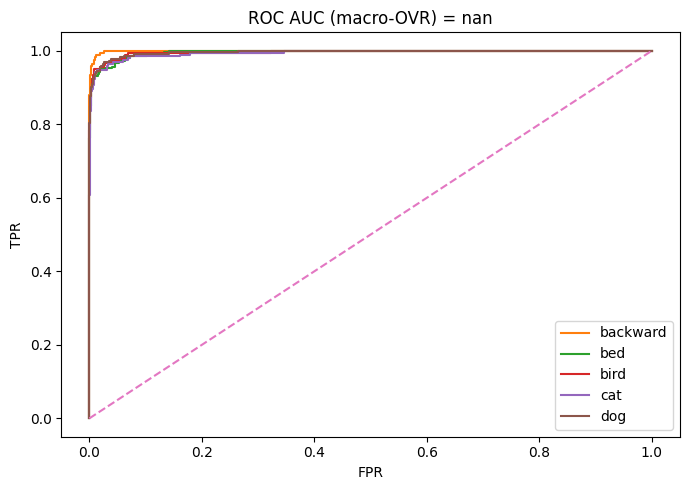

In [ ]:
roc_path = PLOTS_DIR / "roc_macro_ovr_test.png"
plot_roc_ovr(y_true, y_proba, roc_path, [id2label[i] for i in range(num_classes)])

In [ ]:
report = classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_classes)],
                               digits=4, zero_division=0)
print("\n>>> TEST CLASSIFICATION REPORT")
print(report)
with open(ARTIFACTS / "classification_report_test.txt", "w") as f:
    f.write(report)


>>> TEST CLASSIFICATION REPORT
              precision    recall  f1-score   support

 __silence__     0.0000    0.0000    0.0000         0
    backward     0.9444    0.9273    0.9358       165
         bed     0.8689    0.8647    0.8668       207
        bird     0.9560    0.8216    0.8837       185
         cat     0.8549    0.8505    0.8527       194
         dog     0.9944    0.8000    0.8866       220
        down     0.8920    0.8744    0.8831       406
       eight     0.9811    0.8897    0.9332       408
        five     0.9267    0.9371    0.9318       445
      follow     0.8176    0.7558    0.7855       172
     forward     0.8370    0.7290    0.7793       155
        four     0.8663    0.9075    0.8864       400
          go     0.8957    0.8333    0.8634       402
       happy     0.9534    0.9064    0.9293       203
       house     0.8878    0.9110    0.8992       191
       learn     0.7778    0.7826    0.7802       161
        left     0.8680    0.9417    0.9034      

In [ ]:
print("\nArtifacts saved in:")
print(" - Checkpoints :", CKPT_DIR)
print(" - Plots       :", PLOTS_DIR)
print(" - Metrics CSV :", metrics_csv)
print(" - Report TXT  :", ARTIFACTS / 'classification_report_test.txt')


Artifacts saved in:
 - Checkpoints : /content/drive/MyDrive/NLP_Project/artifacts/checkpoints
 - Plots       : /content/drive/MyDrive/NLP_Project/artifacts/plots
 - Metrics CSV : /content/drive/MyDrive/NLP_Project/artifacts/metrics.csv
 - Report TXT  : /content/drive/MyDrive/NLP_Project/artifacts/classification_report_test.txt


## Saving the final model

In [ ]:
MODEL_PATH = ARTIFACTS / "final_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to: {MODEL_PATH}")

Model saved to: /content/drive/MyDrive/NLP_Project/artifacts/final_model.pth
